In [1]:
import random 
import numpy as np
import pandas as pd
import os
import gc
import sys
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.linalg as LA
np.random.seed(42)

import base64

# Data Preparation

In [2]:
### load data
train_df = pd.read_csv('train.csv')
train_df = train_df.drop(['Name', 'RescuerID'], axis=1)

# AdoptionSpeed - Categorical speed of adoption, range from 0 - 4
# 4 -> No adoption after 100 days of being listed, otherwise adopted within 90 days after listing
# convert adoption speed to adopted
train_df['AdoptionSpeed'] = train_df['AdoptionSpeed'].apply(lambda x: 1 if x != 4 else 0)
train_df = train_df.rename({'AdoptionSpeed': 'Adopted'}, axis=1)

### Sentiment Analysis Data

In [3]:
### import sentiment feature which contains sentiment score and magnitude ###
sentiment_dict = {}
for filename in os.listdir('./train_sentiment/'):
    with open('./train_sentiment/' + filename, 'r') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']
    
# append language, magnitude and score to dataframe as new columns
train_df['Language'] = train_df['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'none')
train_df['SentiMagnitude'] = train_df['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
train_df['SentiScore'] = train_df['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

# drop no longer needed columns
train_df = train_df.drop(['Language', 'PetID'], axis=1)

In [4]:
# current features
train_df.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'Description', 'PhotoAmt', 'Adopted', 'SentiMagnitude', 'SentiScore'],
      dtype='object')

# Feature Engineering

### Feature Selection and Modification

In [5]:
### categorical feature modification
# modify the following columns so the labels are: 1=Yes, 2=Not Sure, 3=No
# based on the intuition that 'yes' should be further away from 'No' but
# closer to 'Not sure' -> increased accuracy by ~1-3% for different models
modify_cols = ['Vaccinated', 'Dewormed', 'Sterilized']
def modify_cond(x):
    if x == 2:
        return 3
    elif x == 3:
        return 2
    else:
        return 1
    
for col in modify_cols:
    train_df[col] = train_df[col].apply(modify_cond)

In [6]:
### Incorporate word count and average word length of the description as new features
train_df['Description'] = train_df['Description'].fillna('')
train_df['DescriptionLen'] = train_df['Description'].str.len()
train_df['WordCount'] = train_df['Description'].apply(lambda x:len(x.split()))
train_df['AvgWordLen'] = train_df['Description'].apply(lambda x: np.mean([len(i) for i in x.split()]) if x else 0)

In [7]:
### standardize numerical features -> rarely improves prediction
#train_df['Age'] = (train_df['Age']-train_df['Age'].mean())/train_df['Age'].std()
#train_df['Fee'] = (train_df['Fee']-train_df['Fee'].mean())/train_df['Fee'].std()
#train_df['PhotoAmt'] = (train_df['PhotoAmt']-train_df['PhotoAmt'].mean())/train_df['PhotoAmt'].std()

### Extract TF-IDF Score from Pets' Description

In [8]:
### compute TF-IDF score
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 

def get_description_score(description_col):
    """
    Compute the TF-IDF score for each word in each description, sum and
    divide by the number of words. Use the result as description score
    
    """
    tokenizer = TweetTokenizer()
    vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenizer.tokenize)

    vectorizer.fit(description_col.values)
    tfidf_mat = vectorizer.transform(description_col)
    
    tfidf_score_sum = tfidf_mat.sum(axis=1)
    
    score_col = np.zeros((len(description_col), 1))
    for index,description in enumerate(description_col):
        score_col[index] = tfidf_score_sum[index] / (len(tokenizer.tokenize(description)) + 1)
    
    return score_col

In [9]:
### build the column for description score
score_col = get_description_score(train_df['Description'])
score_col = pd.DataFrame(score_col, columns=['DescriptionScore'])
train_df = pd.concat([train_df, score_col], axis=1)
train_df = train_df.drop(['Description'], axis=1)

/home/louisfanhz/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
# make a copy for later use
train_df_no_encoding = train_df.copy()

### Encoding

In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
### one-hot encodes color labels ###
color_labels = pd.read_csv('ColorLabels.csv')

# add a row to color_labels denoting color 0 means none
na_row = pd.DataFrame({'ColorID':0, 'ColorName':'None'}, index=[0])
color_labels = pd.concat([na_row, color_labels]).reset_index(drop=True)

# replace colorID with labels
color_cols = ['Color1', 'Color2', 'Color3']
train_df[color_cols] = train_df[color_cols].replace(color_labels['ColorID'].values, color_labels['ColorName'].values)

# one-hot encoding
onehot_enc = OneHotEncoder()
onehot_enc = onehot_enc.fit(train_df[color_cols])
onehot_color_feature_names = onehot_enc.get_feature_names_out(color_cols)
onehot_output = pd.DataFrame(onehot_enc.transform(train_df[color_cols]).toarray(), \
                             columns=onehot_color_feature_names)

train_df = pd.concat([train_df.drop(color_cols, axis=1), onehot_output], axis=1)

In [16]:
### one-hot encodes breed labels ###
breed_labels = pd.read_csv('BreedLabels.csv')

# add a row to breed_labels denoting breed 0 means none
na_row = pd.DataFrame({'BreedID':0, 'BreedName':'None'}, index=[0])
breed_labels = pd.concat([na_row, breed_labels]).reset_index(drop=True)

breed_cols = ['Breed1', 'Breed2']
train_df[breed_cols] = train_df[breed_cols].replace(breed_labels['BreedID'].values, breed_labels['BreedName'].values)

# one-hot encoding
onehot_enc = OneHotEncoder()
onehot_enc = onehot_enc.fit(train_df[breed_cols])
onehot_breed_feature_names = onehot_enc.get_feature_names_out(breed_cols)
onehot_output = pd.DataFrame(onehot_enc.transform(train_df[breed_cols]).toarray(), \
                             columns=onehot_breed_feature_names)

train_df = pd.concat([train_df.drop(breed_cols, axis=1), onehot_output], axis=1)

In [17]:
### one-hot encodes state labels ###
state_labels = pd.read_csv('StateLabels.csv')

state_cols = ['State']
train_df[state_cols] = train_df[state_cols].replace(state_labels['StateID'].values, state_labels['StateName'].values)

# one-hot encoding
onehot_enc = OneHotEncoder()
onehot_enc = onehot_enc.fit(train_df[state_cols])
onehot_state_feature_names = onehot_enc.get_feature_names_out(state_cols)
onehot_output = pd.DataFrame(onehot_enc.transform(train_df[state_cols]).toarray(), \
                             columns=onehot_state_feature_names)

train_df = pd.concat([train_df.drop(state_cols, axis=1), onehot_output], axis=1)

### Dimensionality Reduction

In [18]:
### use PCA to reduce dimension
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

columns_to_reduce = np.concatenate((onehot_color_feature_names,
                                    onehot_breed_feature_names,
                                    onehot_state_feature_names), axis=None)

pca = PCA(n_components = columns_to_reduce.shape[0])
pca.fit(train_df[columns_to_reduce])

# cumulative sum of variance explained with [n] features
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)

# get the number of components enough to explain 90% of the data
num_components_90 = np.sum(var <= 90)

# get reduced columns
columns_reduced = pca.transform(train_df[columns_to_reduce])[:, :num_components_90]

# modify train_df
pc_names = ['pc_'+str(i+1) for i in range(columns_reduced.shape[1])]
train_df = pd.concat([train_df.drop(columns_to_reduce, axis=1),
                      pd.DataFrame(columns_reduced, columns=pc_names)], axis=1)

In [19]:
train_df.columns

Index(['Type', 'Age', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated',
       'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'VideoAmt',
       'PhotoAmt', 'Adopted', 'SentiMagnitude', 'SentiScore', 'DescriptionLen',
       'WordCount', 'AvgWordLen', 'DescriptionScore', 'pc_1', 'pc_2', 'pc_3',
       'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10', 'pc_11',
       'pc_12', 'pc_13', 'pc_14', 'pc_15', 'pc_16', 'pc_17', 'pc_18', 'pc_19',
       'pc_20', 'pc_21', 'pc_22', 'pc_23', 'pc_24', 'pc_25', 'pc_26', 'pc_27',
       'pc_28'],
      dtype='object')

# Model Training

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

### global variable to keep info for plotting
model_result = {}

### Feature Importance using Gradient Boosting (lgb supports categorical feature encoding)

In [21]:
### Gradient boosting decision tree Using LightGMB library. Cross-validated
### for plotting feature importance
### check https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
### specifically the section 'categorical feature support'
import lightgbm as lgb

def train_model(X, y, params, folds, categorical_cols, plot_feature_importance=False, averaging='usual'):
    result_dict = {}
    scores = []
    feature_importance = pd.DataFrame()
    
    # train on training set and test on validation set
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
        valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_cols)

        model = lgb.train(params,
                          train_data,
                          num_boost_round=20000,
                          valid_sets=[train_data, valid_data],
                          categorical_feature=categorical_cols,
                          callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)])

        del train_data, valid_data

        y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
        y_pred_valid = y_pred_valid.round(decimals=0).astype(int)
        del X_valid
        gc.collect()

        score = accuracy_score(y_valid, y_pred_valid)
        scores.append(score)
        print('Fold acc:', score)
        print('')

        # feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importance()
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if plot_feature_importance:
        feature_importance["importance"] /= folds.n_splits
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('LGB Features (avg over folds)');

        result_dict['feature_importance'] = feature_importance
                
    return result_dict

Fold 1 started at Tue Dec 13 21:55:49 2022
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Training until validation scores don't improve for 200 rounds


/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	training's binary_logloss: 0.14726	valid_1's binary_logloss: 0.48304
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.230781	valid_1's binary_logloss: 0.477959
Fold acc: 0.7675891963987996

Fold 2 started at Tue Dec 13 21:55:55 2022
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Training until validation scores don't improve for 200 rounds


/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	training's binary_logloss: 0.147261	valid_1's binary_logloss: 0.48757
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.21138	valid_1's binary_logloss: 0.48356
Fold acc: 0.7769256418806268

Fold 3 started at Tue Dec 13 21:56:01 2022
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Training until validation scores don't improve for 200 rounds


/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	training's binary_logloss: 0.148125	valid_1's binary_logloss: 0.475935
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.213139	valid_1's binary_logloss: 0.472695
Fold acc: 0.7712570856952318

Fold 4 started at Tue Dec 13 21:56:07 2022
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Training until validation scores don't improve for 200 rounds


/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	training's binary_logloss: 0.146909	valid_1's binary_logloss: 0.478958
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.209002	valid_1's binary_logloss: 0.47452
Fold acc: 0.7705136757838559

Fold 5 started at Tue Dec 13 21:56:11 2022
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Training until validation scores don't improve for 200 rounds


/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/louisfanhz/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[500]	training's binary_logloss: 0.146	valid_1's binary_logloss: 0.493119
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.213146	valid_1's binary_logloss: 0.48784
Fold acc: 0.7655103402268179

CV mean score: 0.7704, std: 0.0039.


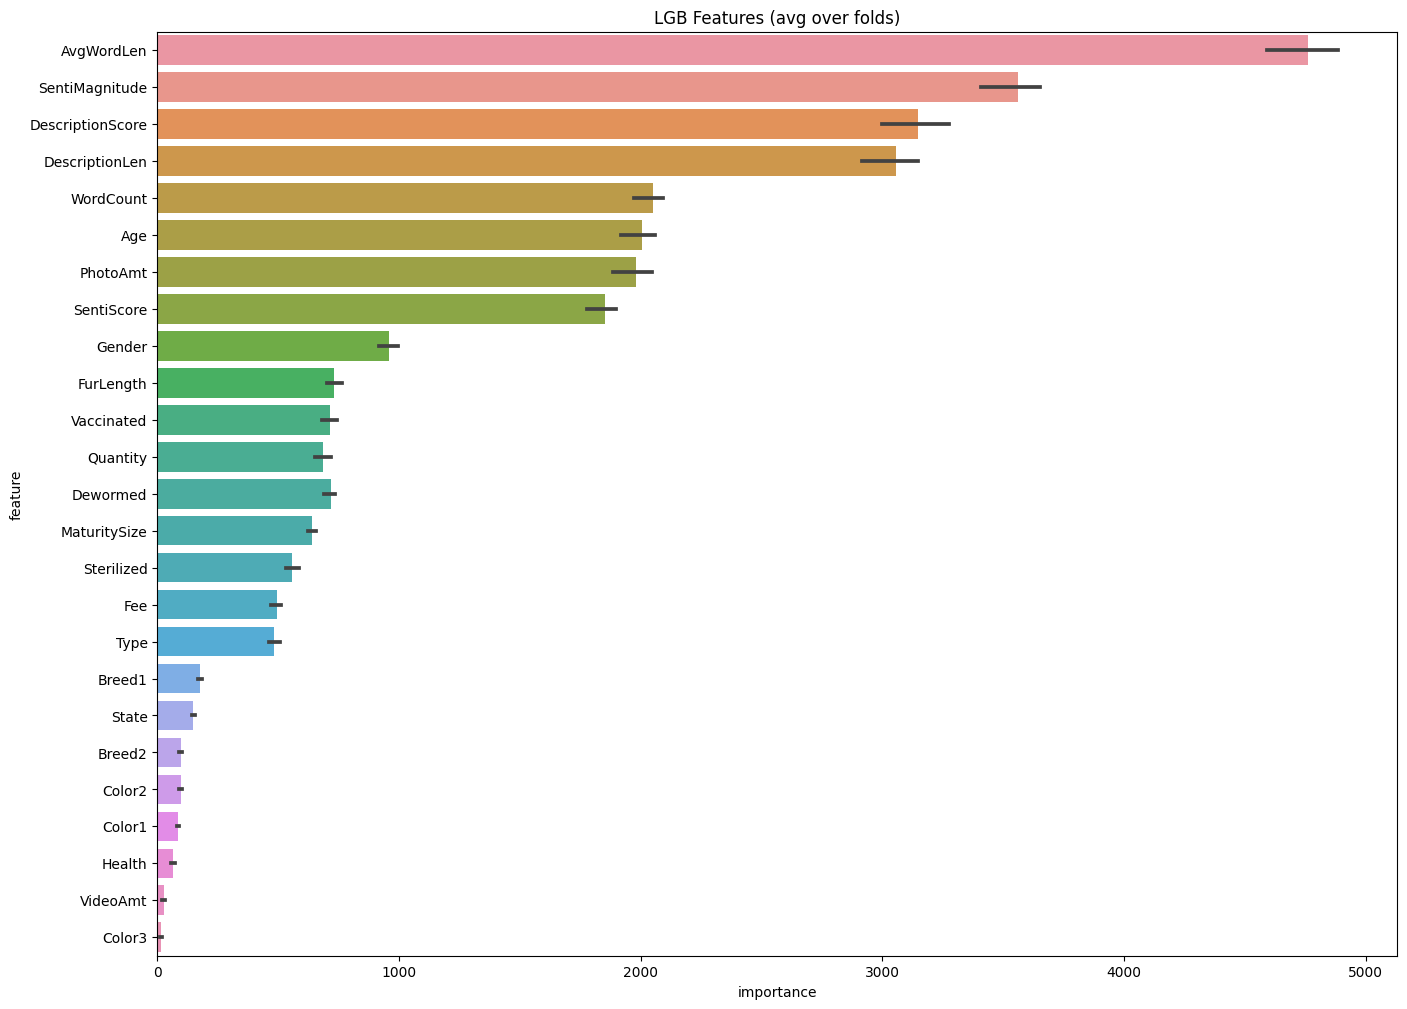

In [22]:
params = {'num_leaves': 512,
         'objective': 'binary',
         'metric': 'binary_logloss',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 3,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         #"lambda_l1": 0.1,
         #"lambda_l2": 0.1,
         "random_state": 42,
         "verbosity": -1}

categorical_cols = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
                    'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
                    'Sterilized', 'Health', 'State']

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

result_dict_lgb = train_model(X=train_df_no_encoding.drop(['Adopted'], axis=1),
                              y=train_df_no_encoding['Adopted'], 
                              params=params,
                              folds=folds,
                              categorical_cols=categorical_cols,
                              plot_feature_importance=True)

### Other Models Learning

In [23]:
### prepare training and testing dataset
X = train_df.drop(['Adopted'], axis=1)
y = train_df['Adopted']
X_no_encode = train_df_no_encoding.drop(['Adopted'], axis=1)
y_no_encode = train_df_no_encoding['Adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_no_encode, X_test_no_encode, y_train_no_encode, y_test_no_encode = \
                            train_test_split(X_no_encode, y_no_encode, test_size=0.3)

#### Helper Function

In [24]:
def train(models, X_train, y_train, X_test, y_test):
    """
    Trains several models and returns the test accuracy for each of them
    Args:
        models: list of model objects
    Returns:
        score (float): list of accuracies of the different fitted models on test set
    """
    train_accuracies = []
    test_accuracies = []
    pred_prob_list = []
    train_time_list = []
    for model in models:
        # fit the data and record time
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time_list.append(time.time() - start_time)
        
        # record result
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        pred_prob = model.predict_proba(X_test)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        test_accuracies.append(accuracy_score(y_test, y_test_pred))
        pred_prob_list.append(pred_prob)

    return train_accuracies, test_accuracies, pred_prob_list, train_time_list

In [25]:
def plot_roc_curve(y_test, model_result):
    """
    plot roc curve given list of labels and prediction probability
    
    """
    for model in model_result:
        fpr, tpr, threshold = metrics.roc_curve(y_test, model_result[model]['predict_proba'][:, 1])
        roc_auc = metrics.auc(fpr, tpr)

        plt.plot(fpr, tpr, label = model + ' (AUC = %0.2f)' % roc_auc)
        plt.legend(loc='lower right')
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    #plt.title('Receiver Operating Characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Logistic Regression (baseline)

In [26]:
from sklearn.linear_model import LogisticRegression

lr_train_acc, lr_test_acc, lr_pred_prob, lr_train_time_list = \
            train([LogisticRegression(random_state=0, max_iter=3000)], X_train, y_train, X_test, y_test)

model_result['LogisticRegression'] = {'train_score': max(lr_train_acc),
                                      'test_score': max(lr_test_acc),
                                      'predict_proba': lr_pred_prob[np.argmax(lr_test_acc)],
                                      'train_time': lr_train_time_list[np.argmax(lr_test_acc)]}

In [27]:
print("train score: ", model_result['LogisticRegression']['train_score'])
print("test score: ", model_result['LogisticRegression']['test_score'])

train score:  0.7389232968080038
test score:  0.7385504668741663


#### Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

def modelDecisionTree():
    """
    Creates model objects for the DecisionTree.

    """
    random_state = 20
    criterions = ['gini', 'entropy', 'log_loss']
    splitters = ['best', 'random']
    obj_dt = []

    for criterion in criterions:
        for splitter in splitters:
            dt_clf = DecisionTreeClassifier(criterion=criterion, 
                                            splitter=splitter,
                                            random_state=random_state)
            obj_dt.append(dt_clf)

    return obj_dt

In [29]:
DTmodels = modelDecisionTree()
dt_train_acc, dt_test_acc, dt_pred_prob, dt_train_time_list = train(DTmodels, X_train, y_train, X_test, y_test)

model_result['DecisionTree'] = {'train_score': max(dt_train_acc),
                                'test_score': max(dt_test_acc),
                                'predict_proba': dt_pred_prob[np.argmax(dt_test_acc)],
                                'train_time': dt_train_time_list[np.argmax(dt_test_acc)]}

In [30]:
print("train score: ", model_result['DecisionTree']['train_score'])
print("test score: ", model_result['DecisionTree']['test_score'])

train score:  0.9999047165316818
test score:  0.6805246776345042


#### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

def modelRandomForest(num_estimators, max_depth):
    """
    Creates model objects for the RandomForest.

    """
    random_state = 20
    obj_rf = []

    for n_estimators in num_estimators:
        for depth in max_depth:
            rf_clf = RandomForestClassifier(n_estimators=n_estimators, 
                                            criterion='log_loss', 
                                            max_depth=depth,
                                            random_state=random_state)
            obj_rf.append(rf_clf)

    return obj_rf

In [32]:
num_estimators = [1,5,10,50,100,150,200,1000]
max_depth = [1,3,5]

RFmodels = modelRandomForest(num_estimators, max_depth)
rf_train_acc, rf_test_acc, rf_pred_prob, rf_train_time_list = train(RFmodels, X_train, y_train, X_test, y_test)

model_result['RandomForest'] = {'train_score': max(rf_train_acc),
                                'test_score': max(rf_test_acc),
                                'predict_proba': rf_pred_prob[np.argmax(rf_test_acc)],
                                'train_time': rf_train_time_list[np.argmax(rf_test_acc)]}

In [33]:
print("train score: ", model_result['RandomForest']['train_score'])
print("test score: ", model_result['RandomForest']['test_score'])

train score:  0.7342544068604098
test score:  0.7323254779902179


#### Gradient Boosting

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

def modelGradientBoost(num_estimators, learning_rate, max_depth):
    """
    Creates model objects for the GradientBoost.

    """
    random_state = 20
    obj_GB = []

    for n_estimators in num_estimators:
        for depth in max_depth:
            GB_clf = GradientBoostingClassifier(n_estimators=n_estimators, \
                                                learning_rate=learning_rate, \
                                                random_state=random_state, \
                                                max_depth=depth)
            obj_GB.append(GB_clf)

    return obj_GB

In [35]:
num_estimators = [1,5,10,50,100,150,200]
learning_rate = 0.1
max_depth = [1,3,5]

GBmodels = modelGradientBoost(num_estimators, learning_rate, max_depth)
GB_train_acc, GB_test_acc, GB_pred_prob, GB_train_time_list = train(GBmodels, X_train, y_train, X_test, y_test)

model_result['GradientBoosting'] = {'train_score': max(GB_train_acc),
                                    'test_score': max(GB_test_acc),
                                    'predict_proba': GB_pred_prob[np.argmax(GB_test_acc)],
                                    'train_time': GB_train_time_list[np.argmax(GB_test_acc)]}

In [36]:
print("train score: ", model_result['GradientBoosting']['train_score'])
print("test score: ", model_result['GradientBoosting']['test_score'])

train score:  0.8762267746545974
test score:  0.762338817252112


#### AdaBoost

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

def modelAdaBoost(num_estimators, learning_rate, max_depth):
    """
    Creates model objects for the AdaBoost.

    """
    random_state = 20
    obj_boost = []

    for n_estimators in num_estimators:
        boost_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
        obj_boost.append(boost_clf)

    return obj_boost

In [38]:
num_estimators = [1,5,10,50,100,150]
learning_rate = 0.1
max_depth = 3

AdaBoostModels = modelAdaBoost(num_estimators, learning_rate, max_depth)
ada_train_acc, ada_test_acc, ada_pred_prob, ada_train_time_list = \
                    train(AdaBoostModels, X_train, y_train, X_test, y_test)

model_result['AdaBoost'] = {'train_score': max(ada_train_acc),
                            'test_score': max(ada_test_acc),
                            'predict_proba': ada_pred_prob[np.argmax(ada_test_acc)],
                            'train_time': ada_train_time_list[np.argmax(ada_test_acc)]}

In [39]:
print("train score: ", model_result['AdaBoost']['train_score'])
print("test score: ", model_result['AdaBoost']['test_score'])

train score:  0.801524535493092
test score:  0.7581147176522899


#### XGBoost

In [40]:
from xgboost import XGBClassifier

def modelXGBoost(num_estimators, L1_reg, L2_reg, max_depth):
    """
    Creates model objects for the XGBoost.

    """
    obj_xgb = []
    params = []

    for n_estimators in num_estimators:
        for depth in max_depth:
            for reg_alpha in L1_reg:
                for reg_lambda in L2_reg:
                    xgb_clf = XGBClassifier(n_estimators=n_estimators,
                                            max_depth=depth,
                                            reg_alpha=reg_alpha,
                                            reg_lambda=reg_lambda)
                    params.append('n_est:{},max_depth:{},alpha:{},lambda:{}'.format(n_estimators, depth, reg_alpha, reg_lambda))
                    obj_xgb.append(xgb_clf)

    return obj_xgb, params

In [41]:
num_estimators = [1,5,10,50,100,300]
L1_reg = [0.01, 0.1, 0.3]
L2_reg = [0.01, 0.1, 0.3]
max_depth = [1,3,5]

XGBmodels, XGBparams = modelXGBoost(num_estimators, L1_reg, L2_reg, max_depth)
XGB_train_acc, XGB_test_acc, XGB_pred_prob, XGB_train_time_list = train(XGBmodels, X_train, y_train, X_test, y_test)

model_result['XGBoost'] = {'train_score': max(XGB_train_acc),
                           'test_score': max(XGB_test_acc),
                           'predict_proba': XGB_pred_prob[np.argmax(XGB_test_acc)],
                           'train_time': XGB_train_time_list[np.argmax(XGB_test_acc)],
                           'parameters': XGBparams[np.argmax(XGB_test_acc)]}

In [42]:
print("train score: ", model_result['XGBoost']['train_score'])
print("test score: ", model_result['XGBoost']['test_score'])

train score:  0.9923773225345403
test score:  0.7663405958203646


#### Kernel SVM (Take hours, don't run)

In [24]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
reg_params = [0.01, 0.1, 1.0, 10.0, 50.0]

ksvm_models = np.empty((len(kernels), len(reg_params)), dtype=object)
ksvm_train_acc = np.zeros((len(kernels), len(reg_params)), dtype=float)
ksvm_test_acc = np.zeros((len(kernels), len(reg_params)), dtype=float)
ksvm_time_run = np.zeros((len(kernels), len(reg_params)), dtype=float)

for k_i, kernel in enumerate(kernels):
    for p_i, reg_param in enumerate(reg_params):
        print('========== training SVM: kernel={}, C={} =========='.format(kernel, reg_param))
        svm_clf = SVC(C=reg_param, kernel=kernel, random_state=20, probability=True)
        start_time = time.time()
        svm_clf.fit(X_train, y_train)
        ksvm_time_run[k_i, p_i] = time.time() - start_time
        ksvm_models[k_i, p_i] = svm_clf
        ksvm_train_acc[k_i, p_i] = accuracy_score(y_train, svm_clf.predict(X_train))
        ksvm_test_acc[k_i, p_i] = accuracy_score(y_test, svm_clf.predict(X_test))
        print('train accuracy = {}'.format(ksvm_train_acc[k_i, p_i]))
        print('test accuracy = {}'.format(ksvm_test_acc[k_i, p_i]))
        print('time run = {}'.format(ksvm_time_run[k_i, p_i]))
        
model_result['SVM'] = {'train_score': np.max(ksvm_train_acc),
                       'test_score': np.max(ksvm_test_acc),
                       'predict_proba': ksvm_models.flatten()[np.argmax(ksvm_test_acc)].predict_proba(X_test),
                       'train_time': ksvm_time_run.flatten()[np.argmax(ksvm_test_acc)]}

========== training SVM: kernel=linear, C=0.01 ==========
train accuracy = 0.7209147212958552
test accuracy = 0.7180969319697643
time run = 220.48916363716125
========== training SVM: kernel=linear, C=0.1 ==========
train accuracy = 0.7209147212958552
test accuracy = 0.7180969319697643
time run = 3415.8800387382507
========== training SVM: kernel=linear, C=1.0 ==========
train accuracy = 0.7209147212958552
test accuracy = 0.7180969319697643
time run = 6729.6468052864075
========== training SVM: kernel=linear, C=10.0 ==========
train accuracy = 0.7209147212958552
test accuracy = 0.7180969319697643
time run = 5993.176003932953
========== training SVM: kernel=linear, C=50.0 ==========
train accuracy = 0.7210100047641734
test accuracy = 0.7183192530013339
time run = 6539.495803833008
========== training SVM: kernel=poly, C=0.01 ==========
train accuracy = 0.7209147212958552
test accuracy = 0.7178746109381947
time run = 85.24798321723938
========== training SVM: kernel=poly, C=0.1 =========

<AxesSubplot: xlabel='Kernel', ylabel='C'>

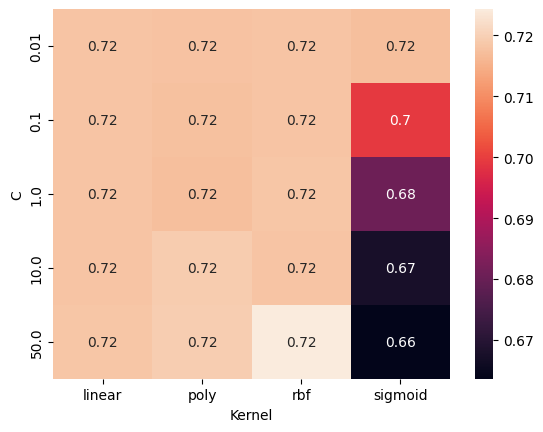

In [25]:
### plot heatmap
kernel_names = np.array([[kernel] * len(reg_params) for kernel in kernels]).flatten()
reg_param_names = np.array([[param for param in reg_params] * len(kernels)]).flatten()
ksvm_result_df = list(zip(kernel_names, reg_param_names, np.array(ksvm_test_acc).flatten()))
ksvm_result_df = pd.DataFrame(ksvm_result_df, columns=['Kernel', 'C', 'Score'])
ksvm_result_df = ksvm_result_df.pivot(index='C', columns='Kernel', values='Score')
sns.heatmap(ksvm_result_df, annot=True)

### ROC curve

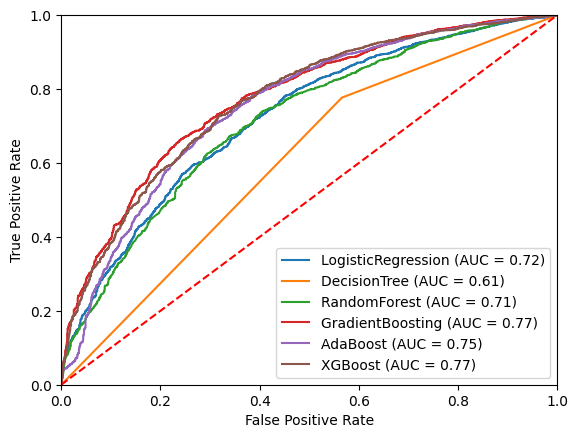

In [43]:
plot_roc_curve(y_test, model_result)

### Train Time Plot

<AxesSubplot: xlabel='Training Time', ylabel='Models'>

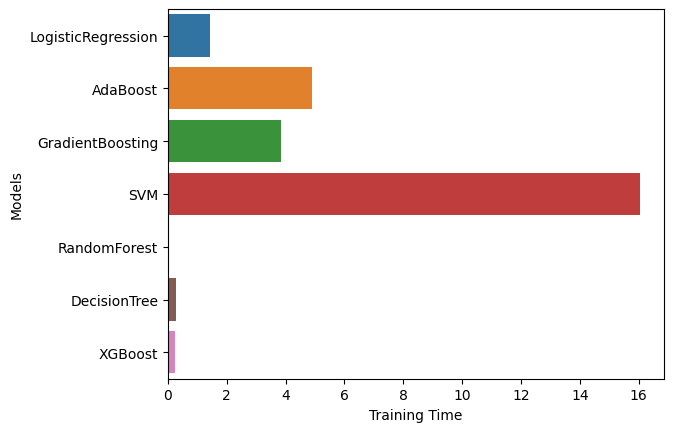

In [379]:
train_time_list = pd.DataFrame([model_result[model]['train_time'] for model in model_result], columns=['Training Time'])
model_names_list = pd.DataFrame([model for model in model_result], columns=['Models'])
train_time_df = pd.concat([model_names_list, train_time_list], axis=1)
sns.barplot(data=train_time_df, y='Models', x='Training Time')

#### AutoML (slightly worse than our tuned model)

In [ ]:
import PipelineProfiler
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

In [72]:
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=10800)
automl.fit(X_train, y_train, dataset_name='Pet_Adoption')

[WARNING] [2022-12-13 12:30:34,472:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-13 12:30:36,119:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-13 12:30:36,975:Client-EnsembleBuilder] No runs were available to build an ensemble from


Process ForkProcess-331:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/louisfanhz/.local/lib/python3.8/site-packages/autosklearn/util/logging_.py", line 317, in start_log_server
    receiver.serve_until_stopped()
  File "/home/louisfanhz/.local/lib/python3.8/site-packages/autosklearn/util/logging_.py", line 347, in serve_until_stopped
    rd, wr, ex = select.select([self.socket.fileno()], [], [], self.timeout)
KeyboardInterrupt


KeyboardInterrupt: 

In [35]:
print(automl.leaderboard())

          rank  ensemble_weight               type      cost   duration
model_id                                                               
14           1             0.06  gradient_boosting  0.242494   5.265580
23           2             0.08      random_forest  0.243360  10.399538
64           3             0.04  gradient_boosting  0.249423   7.954515
63           4             0.02      random_forest  0.250000   7.761124
21           5             0.26           adaboost  0.250289   7.415205
20           6             0.14           adaboost  0.251732   4.673626
16           7             0.08      random_forest  0.254619   9.531533
70           8             0.02        extra_trees  0.272229  23.811462
33           9             0.12           adaboost  0.275982   1.891099
28          10             0.04                sgd  0.279157   2.546134
25          11             0.04      random_forest  0.279734   6.070147
31          12             0.04      random_forest  0.282044   8

In [36]:
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, automl.predict(X_test)))

Accuracy score: 0.7607825700311249


# Experimenting Code

### Data Balancing (using unbalanced data has better performance)

In [13]:
from collections import Counter

### Separate training and testing dataset
X = train_df.drop(['Adopted'], axis=1)
y = train_df['Adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 7505, 0: 2990})
Testing target statistics: Counter({1: 3291, 0: 1207})


In [14]:
### oversample the data
from imblearn.over_sampling import SMOTE

over_sampler = SMOTE(k_neighbors=2)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 7505, 1: 7505})
Testing target statistics: Counter({1: 3291, 0: 1207})


### Explore pets without name

In [ ]:
# train_copy['NoName'] = train_copy['NoName'].apply(lambda x: 'No Name' if x == 1 else 'Otherwise')
Nn_df = train_copy.loc[train_copy['NoName'] == True]

Nn_count = len(Nn_df)
Nn_data = [Nn_count, len(train_copy) - Nn_count]

plt.pie(x=Nn_data, labels=['No Name', 'Otherwise'], autopct=autopct_format(Nn_data))
plt.title('No name percentage');

In [ ]:
Nn_adoption_count = len(Nn_df.loc[Nn_df['Adopted'] == 'Adopted'])
Nn_data = [Nn_adoption_count, len(Nn_df) - Nn_adoption_count]

plt.pie(x=Nn_data, labels=['Adopted', 'Not Adopted'], autopct=autopct_format(Nn_data))
plt.title('No name adoption percentage');